# <center> Grad-CAM </center>

In [1]:
!pip install opencv-python

In [2]:
!pip install tensorflow

In [4]:
from PIL import Image
from tensorflow.keras.preprocessing import image as image_
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

## 1. grad-CAM

In [5]:
labels = ['cat', 'dog']

In [6]:
def grad_cam(model, image, layer_name, cat_class_index=None):
    
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_div = image_array / 255
    
    if cat_class_index is None:
        cat_class_index = np.argmax(model.predict(np.array([image_div])), axis=-1)[0]
    
    print('----------------------------------------------------')
    print('Affichage des heatmaps pour la classe ', labels[cat_class_index])
    print('----------------------------------------------------')
    print('')
    
    # Get gradients for the class on the last layer
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image_div])) #get activations maps + predictions from last conv layer
        
        if cat_class_index is None:
            loss = predictions[0]
        else:
            loss = predictions[:, cat_class_index] # the variable loss gets the probability of belonging to the defined class (the predicted class on the
        
    output = conv_outputs[0] #activations maps from last conv layer
    output = np.maximum(output.numpy(), 0) # Apply ReLu
    
    random = np.random.randint(output.shape[2], size=5)
    random2 = np.random.randint(output.shape[2], size=5)
    
    print('HEATMAP WITH WEIGTH AFTER TRAINING')
    print('----------------------------------')
    
    # Get randoms MAPs
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random):
        map_ = np.ones(output.shape[0: 2])
        ax = plt.subplot(1, 5, k + 1)
        map_ = output[:, :, compt]
        map_ = np.maximum(map_, 0)
        map_ = (map_ - map_.min()) / (map_.max() - map_.min())
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt))
        plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random2):
        map_ = np.ones(output.shape[0: 2])
        ax = plt.subplot(1, 5, k + 1)
        map_ = output[:, :, compt]
        map_ = np.maximum(map_, 0)
        map_ = (map_ - map_.min()) / (map_.max() - map_.min())
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt))
        plt.axis("off")
    plt.show()
                
    plt.figure(figsize=(16, 16))    
    
    # Concatenate all futeares maps
    output_mean = np.mean([output[:, :, i] for i in range(output.shape[2])], axis=0)
    output_mean = np.maximum(output_mean, 0)
        
    # Get mask
    output_mean_mask = np.zeros(output.shape[0: 2], dtype = np.float32)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if output_mean[i][j] < np.mean(output_mean[:, :]):
                output_mean_mask[i][j] = 255
            else:
                output_mean_mask[i][j] = 0
    
    # Plot Features MAPs means for weigth
    ax = plt.subplot(1, 3, 1)
    output_mean = cv.resize(output_mean, (224, 224))
    plt.imshow(output_mean)
    plt.title('Features MAPs means')
    plt.axis("off")
    
    # Plot output with weigth map
    heatmap_weigth = (output_mean - output_mean.min()) / (output_mean.max() - output_mean.min())
    output_mean = cv.applyColorMap(np.uint8(255*heatmap_weigth), cv.COLORMAP_JET)
    output_image_weigth = cv.addWeighted(image_array.astype('uint8'), 0.5, output_mean, 0.5, 0)
    ax = plt.subplot(1, 3, 2)
    plt.imshow(output_image_weigth)
    plt.axis("off")
    
    # Plot mask with weigth map
    ax = plt.subplot(1, 3, 3)
    mask_weigth = image_array.astype('uint8')
    output_mean_mask = cv.resize(output_mean_mask, (224, 224))
    for i in range(mask_weigth.shape[0]):
        for j in range(mask_weigth.shape[1]):
            if output_mean_mask[i][j] > 0:
                mask_weigth[i, j, 0] = 0
                mask_weigth[i, j, 1] = 0
                mask_weigth[i, j, 2] = 0
    
    plt.imshow(mask_weigth)
    plt.axis("off")
    plt.show()
    
    
    # Get gradients for each pixels last convolutional layer
    
    with tf.device('/CPU:0'):
        grads = tape.gradient(loss, conv_outputs)[0] #function to obtain gradients from last conv layer
        # print(grads.shape)

        
    print('HEATMAP WITH GRADIENT AFTER TRAINING')
    print('------------------------------------')
    
    # Get 5 randoms MAPs
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random):
        map_ = np.ones(grads.shape[0: 2])
        ax = plt.subplot(1, 5, k + 1)
        map_ = grads[:, :, compt]
        map_ = np.maximum(map_, 0)
        # map_ = (map_ - map_.min()) / (map_.max() - map_.min())
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt))
        plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random2):
        map_ = np.ones(grads.shape[0: 2])
        ax = plt.subplot(1, 5, k + 1)
        map_ = grads[:, :, compt]
        map_ = np.maximum(map_, 0)
        # map_ = (map_ - map_.min()) / (map_.max() - map_.min())
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt))
        plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 16))    
    
    # Concatenate all futeares maps
    grad_mean = np.mean([grads[:, :, i] for i in range(grads.shape[2])], axis=0)
    grad_mean = np.maximum(grad_mean, 0) # Apply ReLu
        
    # Get mask
    grad_mean_mask = np.zeros(grads.shape[0: 2], dtype = np.float32)
    for i in range(grads.shape[0]):
        for j in range(grads.shape[1]):
            if grad_mean[i][j] < np.mean(grad_mean[:, :]):
                grad_mean_mask[i][j] = 255
            else:
                grad_mean_mask[i][j] = 0
    
    # Plot Features MAPs means for gradient
    ax = plt.subplot(1, 3, 1)
    grad_mean = cv.resize(grad_mean, (224, 224))
    plt.imshow(grad_mean)
    plt.title('Features MAPs means')
    plt.axis("off")
    
    # Plot output with gradient map
    heatmap_grad = (grad_mean - grad_mean.min()) / (grad_mean.max() - grad_mean.min())
    grad_mean = cv.applyColorMap(np.uint8(255*heatmap_grad), cv.COLORMAP_JET)
    output_image_grad = cv.addWeighted(image_array.astype('uint8'), 0.5, grad_mean, 0.5, 0)
    ax = plt.subplot(1, 3, 2)
    plt.imshow(output_image_grad)
    plt.axis("off")
    
    # Plot mask with gradient map
    ax = plt.subplot(1, 3, 3)
    mask_grad = image_array.astype('uint8')
    grad_mean_mask = cv.resize(grad_mean_mask, (224, 224))
    for i in range(mask_grad.shape[0]):
        for j in range(mask_grad.shape[1]):
            if grad_mean_mask[i][j] > 0:
                mask_grad[i, j, 0] = 0
                mask_grad[i, j, 1] = 0
                mask_grad[i, j, 2] = 0
    
    plt.imshow(mask_grad)
    plt.axis("off")
    plt.show()
    
    
    # Grad-cam
    
    weights = tf.reduce_mean(grads, axis=(0, 1)) # Compute weigth for each map
    
    print('HEATMAP WITH GRAD-CAM AFTER TRAINING')
    print('------------------------------------')
    
    # Get 5 randoms MAPs
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random):
        map_ = np.ones(grads.shape[0: 2])
        ax = plt.subplot(1, 5, k + 1)
        map_ = weights[compt] * output[:, :, compt]
        map_ = np.maximum(map_, 0)
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt) + '\n (' + str(weights[compt].numpy()) + ')')
        plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(16, 16))
    for k, compt in enumerate(random2):
        map_ = np.ones(grads.shape[0: 2])
        ax = plt.subplot(1, 5, k + 1)
        map_ = weights[compt] * output[:, :, compt]
        map_ = np.maximum(map_, 0)
        # map_ = (map_ - map_.min()) / (map_.max() - map_.min())
        plt.imshow(map_)
        plt.title('Feature MAP number ' + str(compt) + '\n (' + str(weights[compt].numpy()) + ')')
        plt.axis("off")
    plt.show()
    
    cam = np.ones(output.shape[0: 2], dtype = np.float32)
    
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
        
    cam = np.maximum(cam.numpy(), 0) # Apply ReLu
    
    # Get mask
    grad_mask = np.zeros(grads.shape[0: 2], dtype = np.float32)
    for i in range(grads.shape[0]):
        for j in range(grads.shape[1]):
            if cam[i][j] < np.mean(cam[:, :]):
                grad_mask[i][j] = 255
            else:
                grad_mask[i][j] = 0
        
    cam = cv.resize(cam, (224, 224)) # Resize to same with imput image
    
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    
    plt.figure(figsize=(16, 16))
   
    cam = cv.applyColorMap(np.uint8(255*heatmap), cv.COLORMAP_JET)
    ax = plt.subplot(1, 3, 1)
    plt.imshow(cam)
    plt.axis("off")
    
    output_image = cv.addWeighted((np.array(image)).astype('uint8'), 0.5, cam, 0.5, 0)
    ax = plt.subplot(1, 3, 2)
    plt.imshow(output_image)
    plt.axis("off")
    
    # Plot mask with gradient map
    ax = plt.subplot(1, 3, 3)
    mask_ = image_array.astype('uint8')
    grad_mask = cv.resize(grad_mask, (224, 224))
    for i in range(mask_.shape[0]):
        for j in range(mask_.shape[1]):
            if grad_mask[i][j] > 0:
                mask_[i, j, 0] = 0
                mask_[i, j, 1] = 0
                mask_[i, j, 2] = 0
    
    plt.imshow(mask_)
    plt.axis("off")
    
    plt.show()
    

## 2. Load model

In [7]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

model = load_model('my_model_softmax.h5')
model.load_weights('./weights/my_weights_softmax')
model.summary()

2021-12-16 13:11:38.682503: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-16 13:11:38.684223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/franel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-16 13:11:38.684250: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 13:11:38.684273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (latitude-5400-02): /proc/driver/nvidia/version does not exist


Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 115, 115, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

## 1. Load image

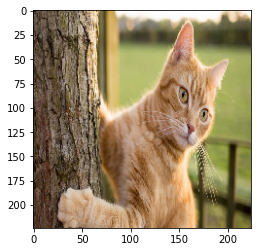

[[0.9868117  0.01318834]]
La classe prédite est cat

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


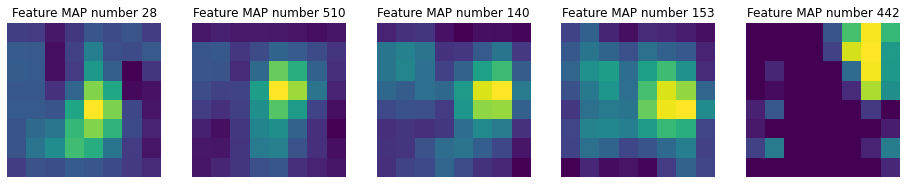

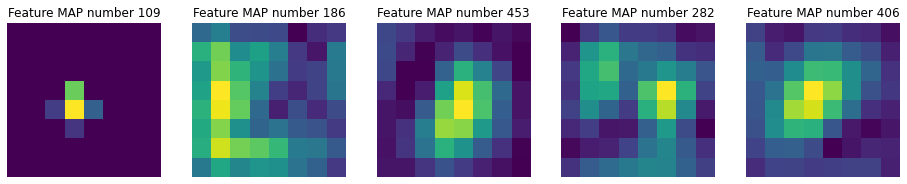

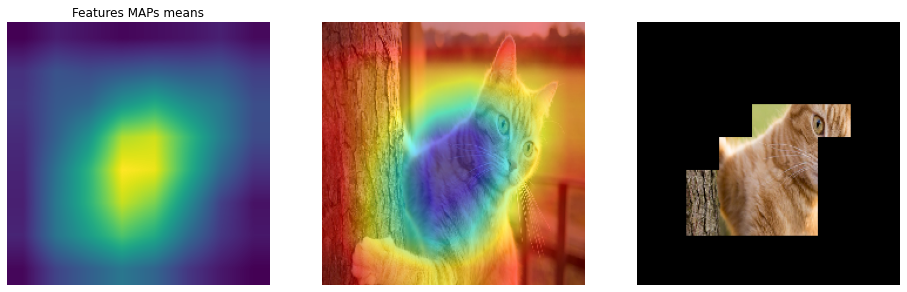

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


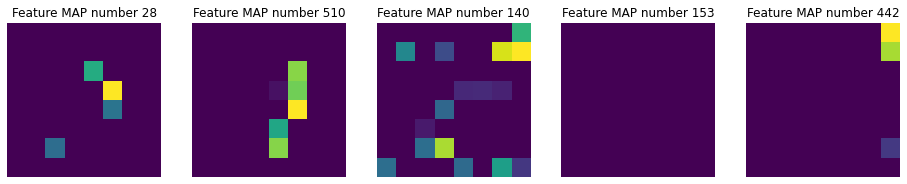

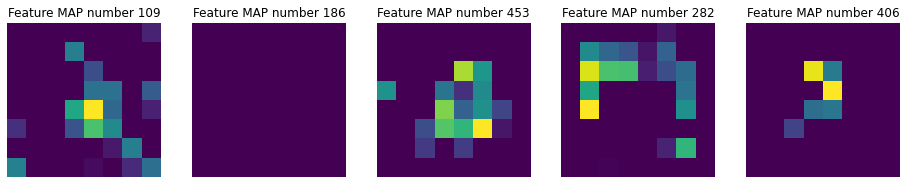

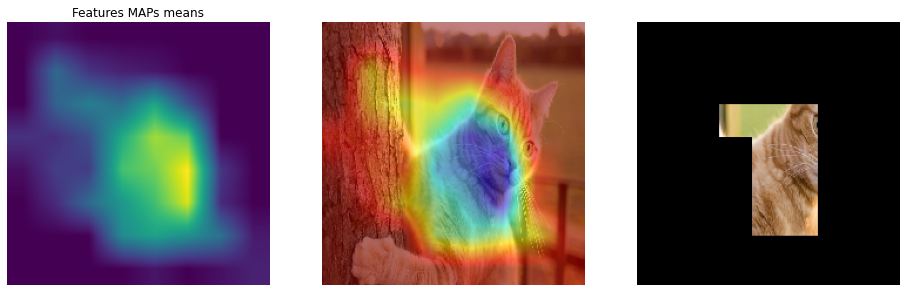

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


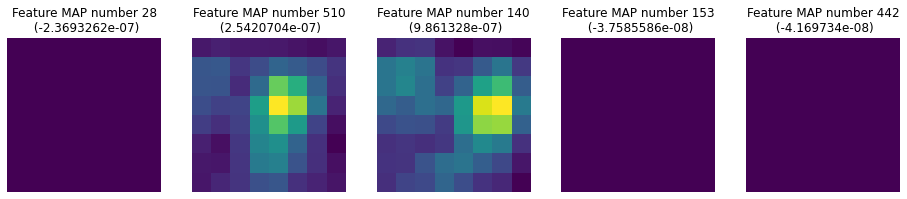

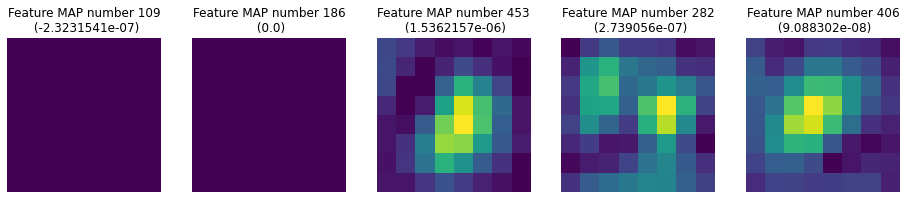

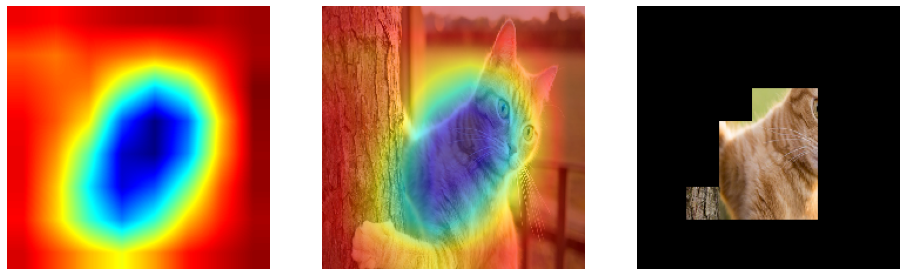

In [8]:
iamge_path = 'test/test4.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19')

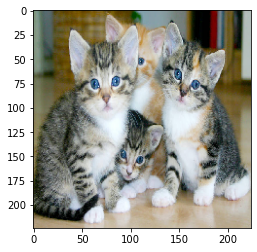

[[0.8792561  0.12074395]]
La classe prédite est cat

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


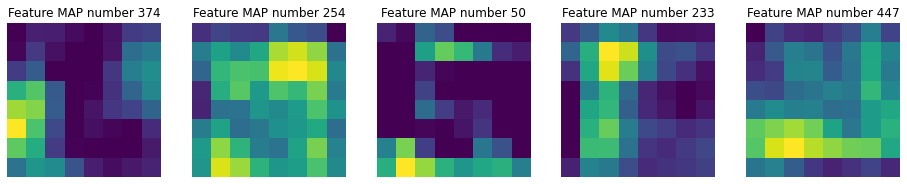

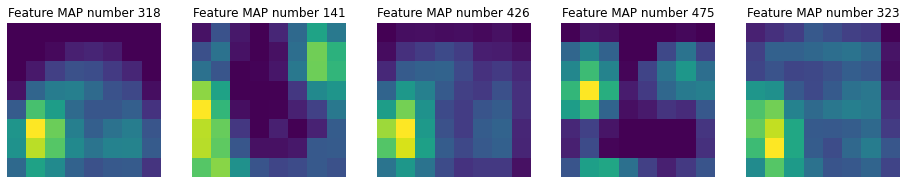

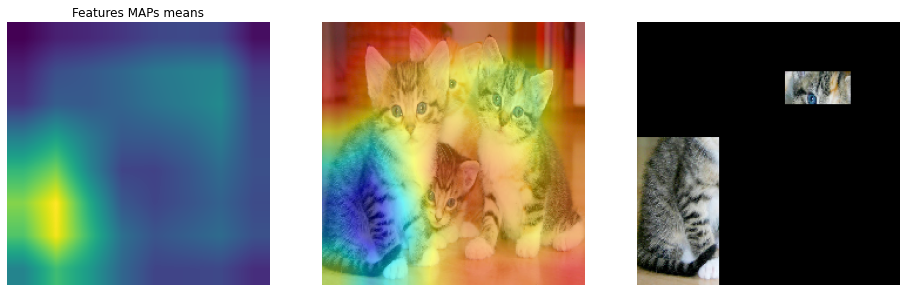

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


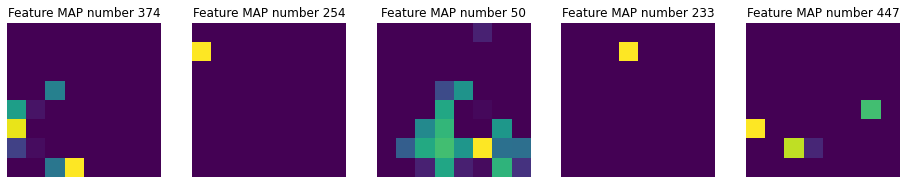

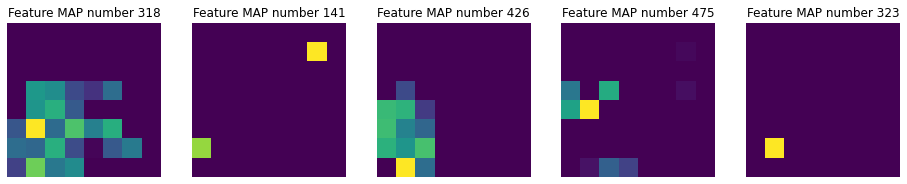

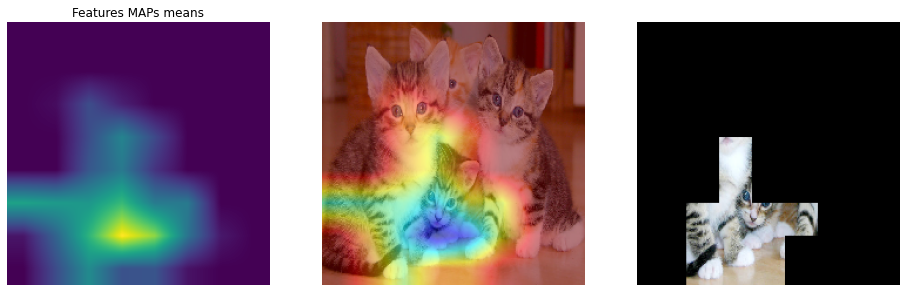

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


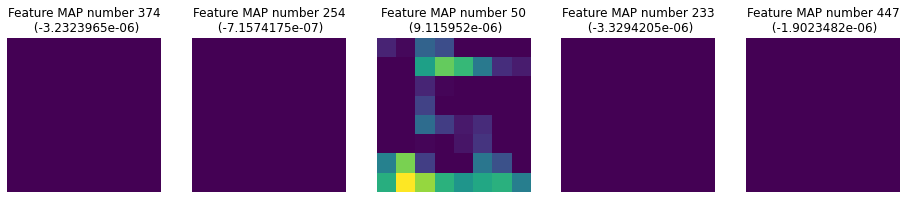

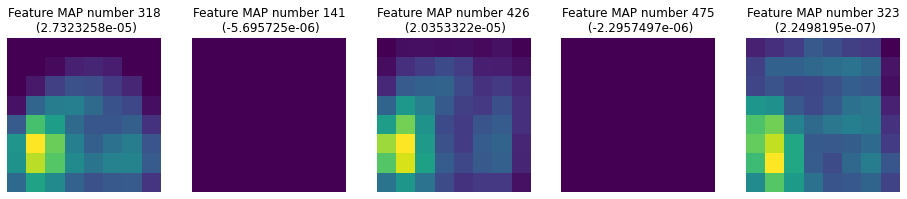

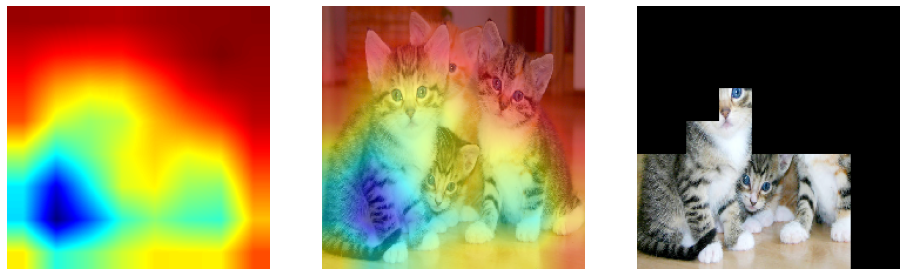

In [9]:
iamge_path = 'test/test3.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19')

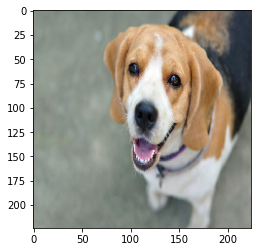

[[7.3874684e-10 1.0000000e+00]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


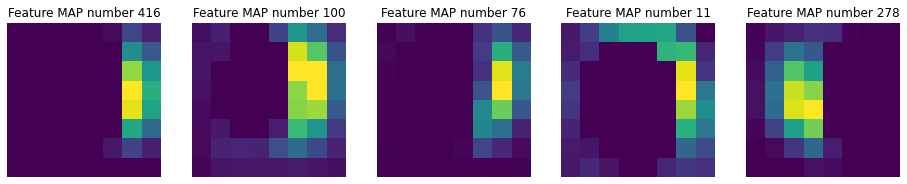

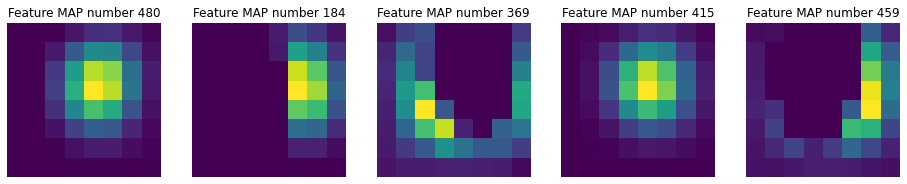

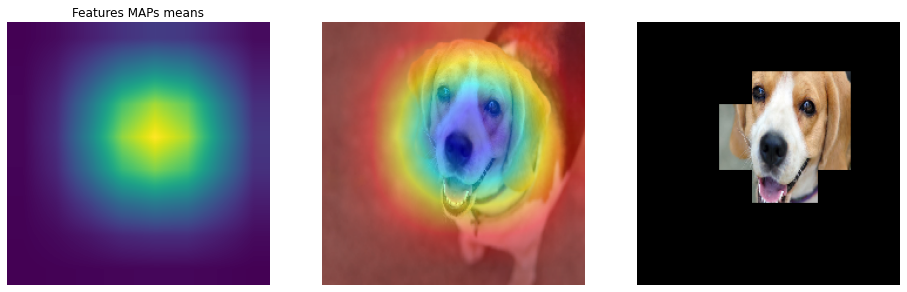

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


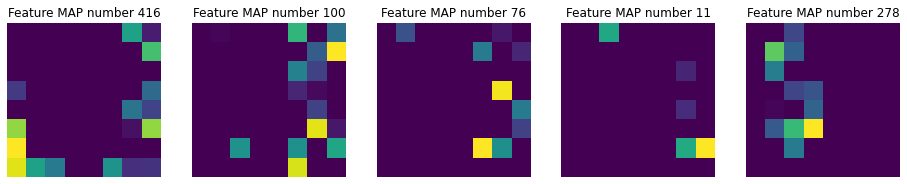

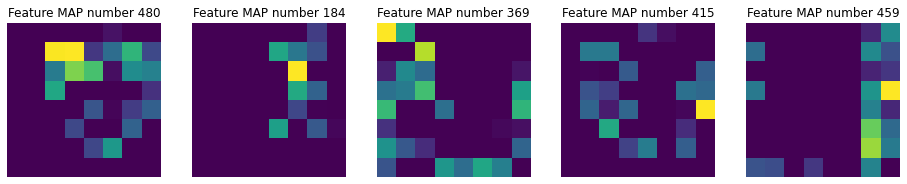

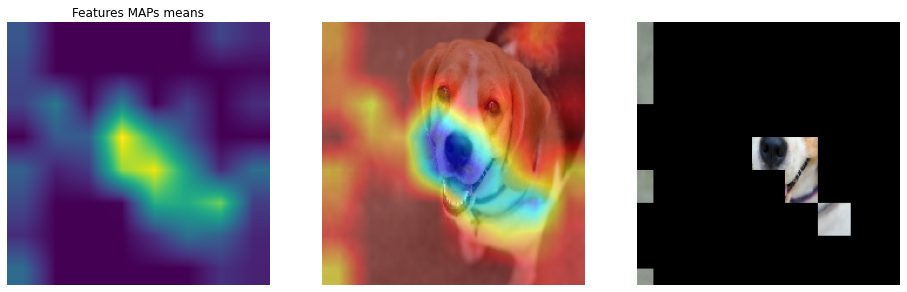

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


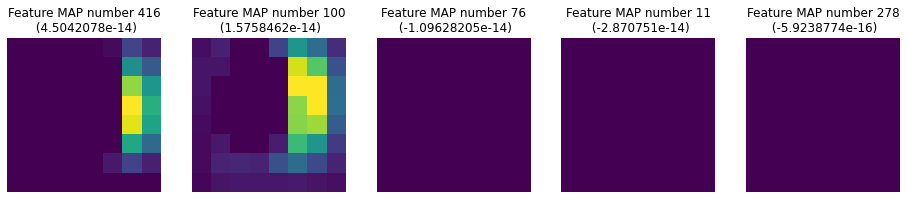

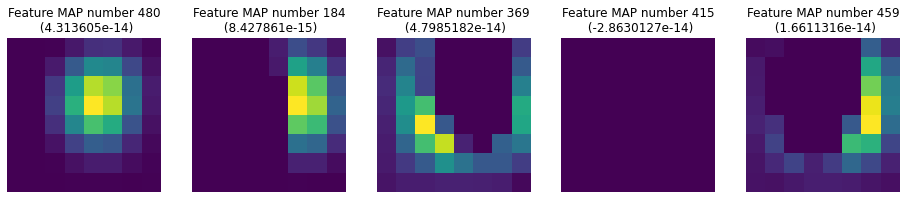

/tmp/ipykernel_1164969/1245606894.py:235: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())


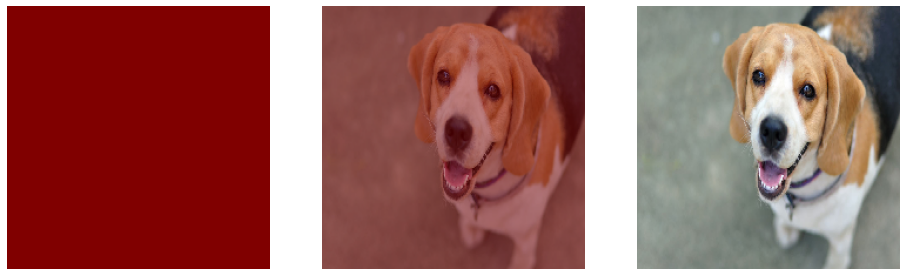

In [11]:
iamge_path = 'test/test2.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19', cat_class_index=preds[0])

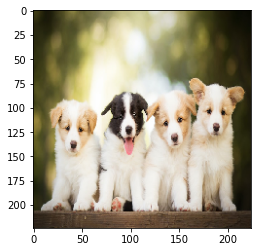

[[0.28210735 0.71789265]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


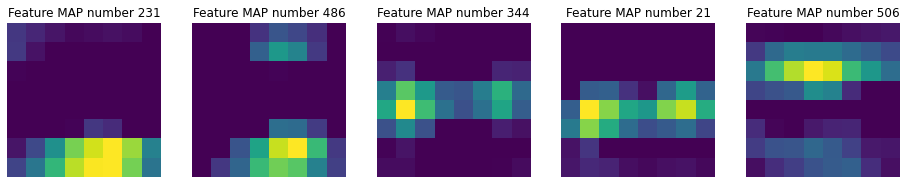

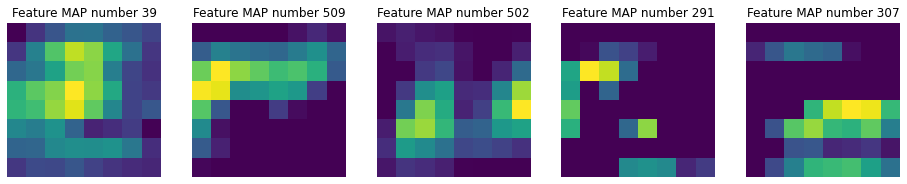

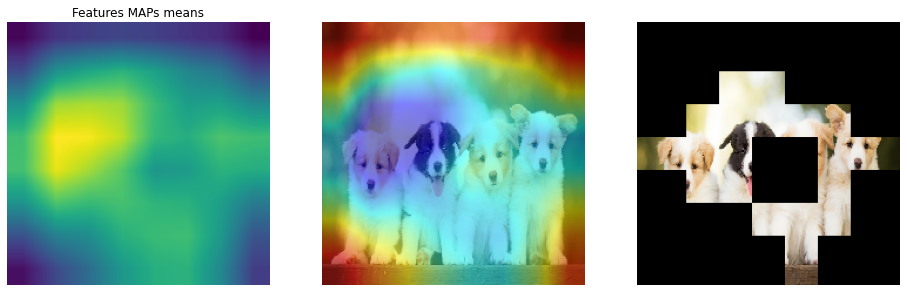

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


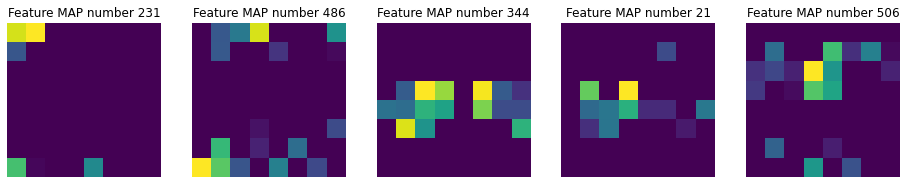

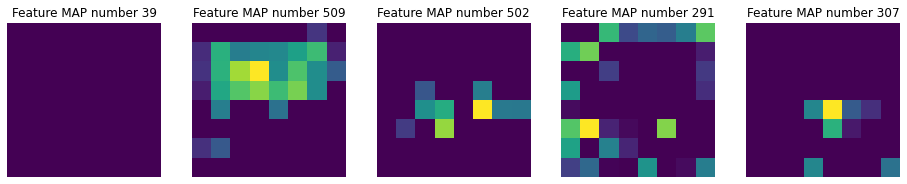

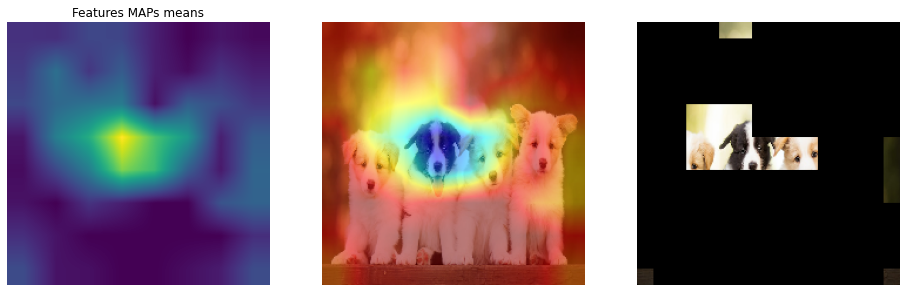

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


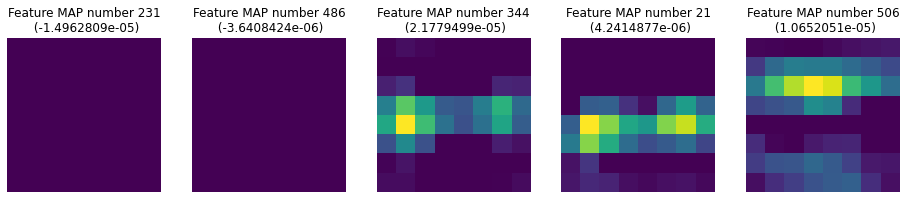

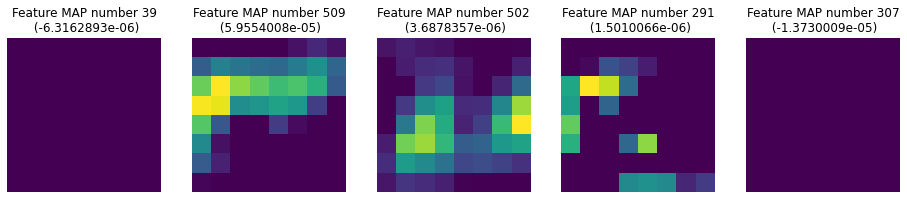

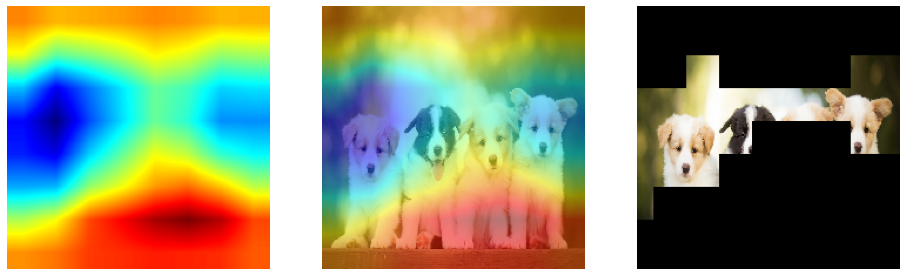

In [12]:
iamge_path = 'test/test1.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19', cat_class_index=preds[0])

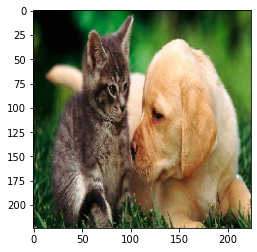

[[0.23751427 0.76248574]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


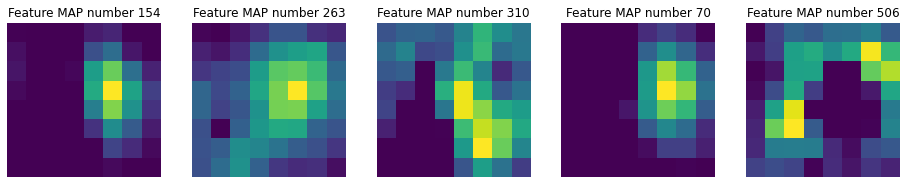

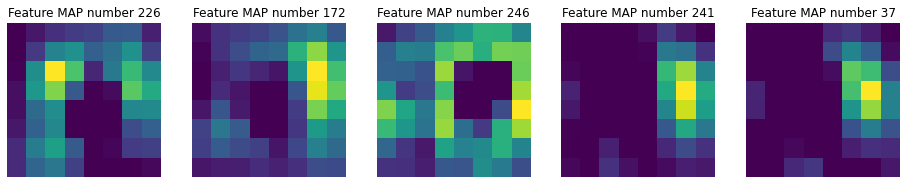

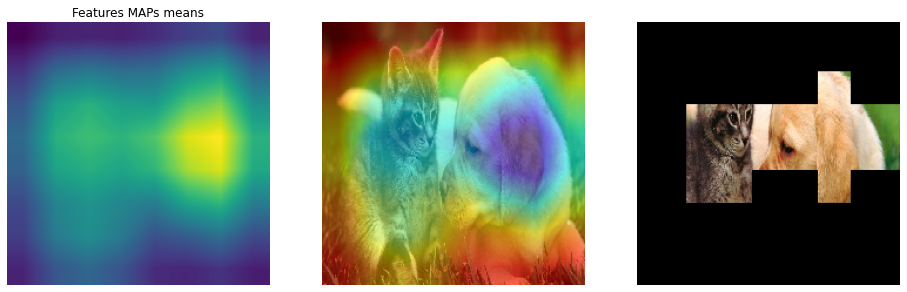

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


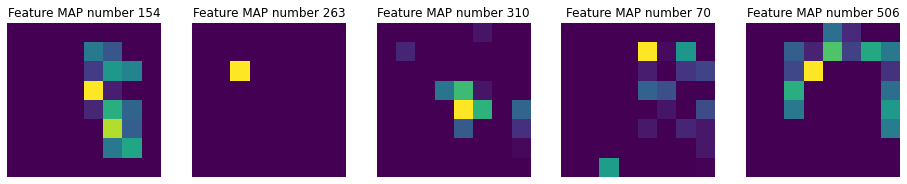

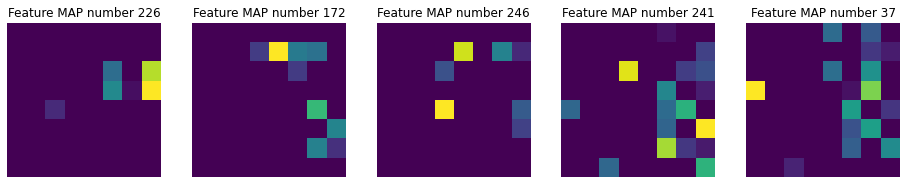

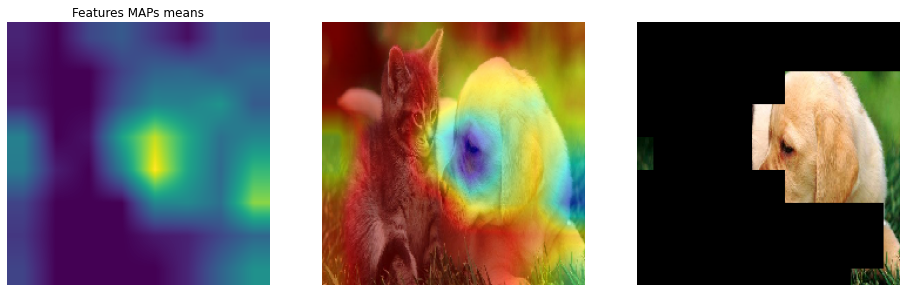

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


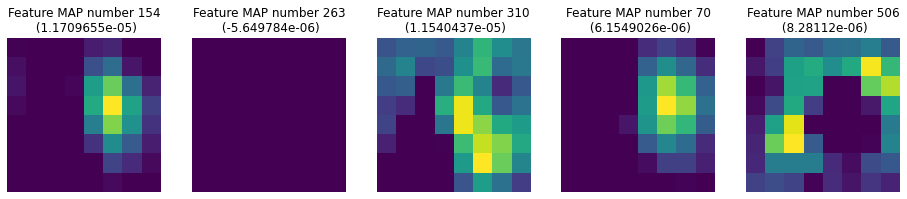

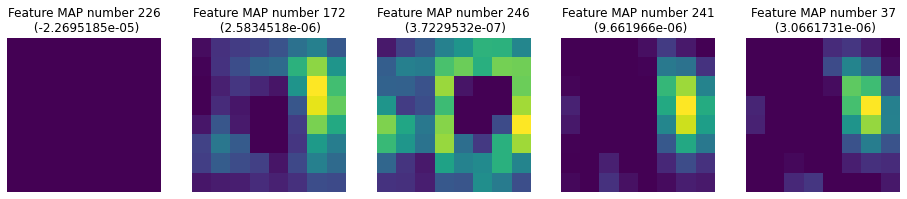

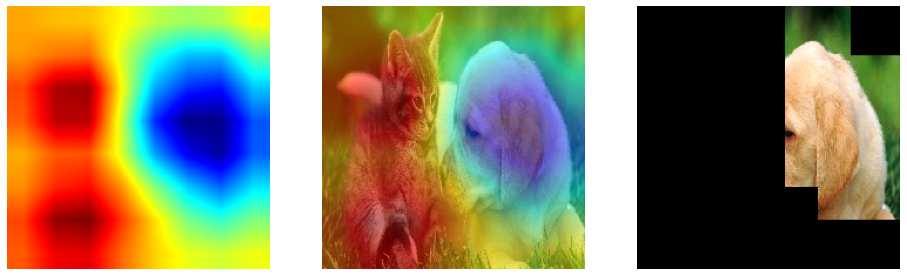

In [13]:
iamge_path = 'test/test5.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19')

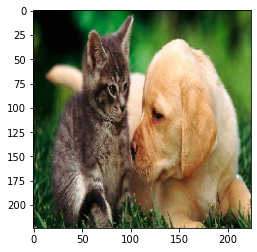

[[0.23751427 0.76248574]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


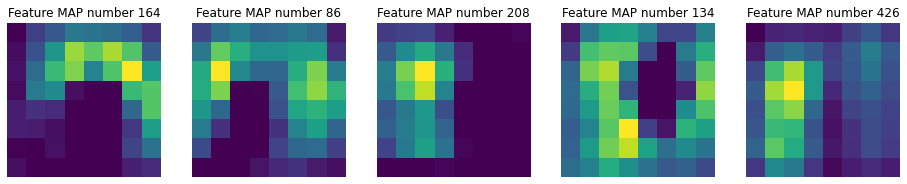

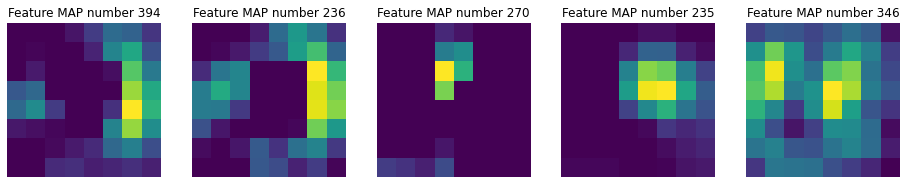

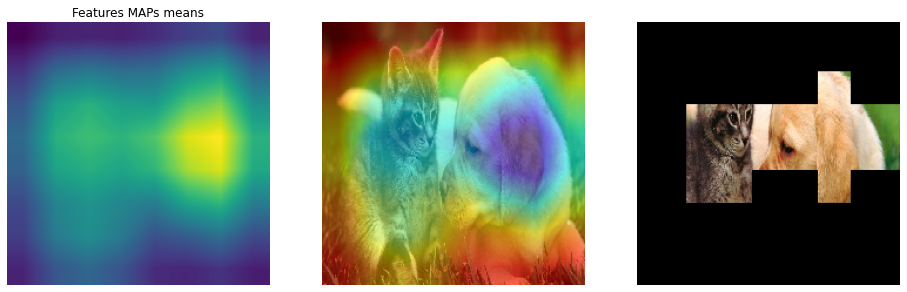

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


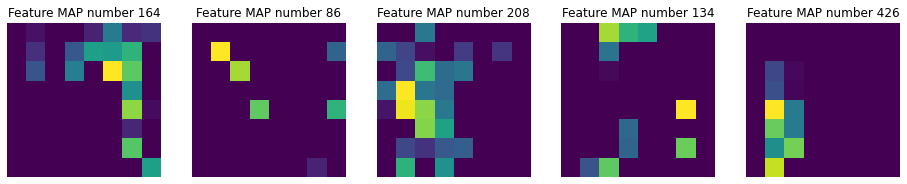

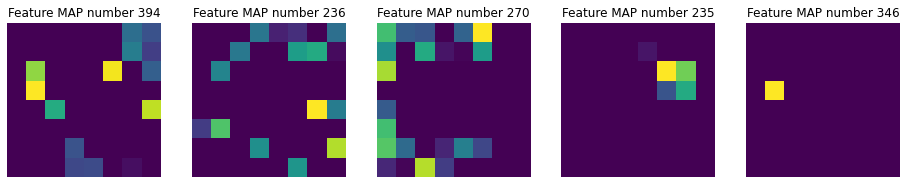

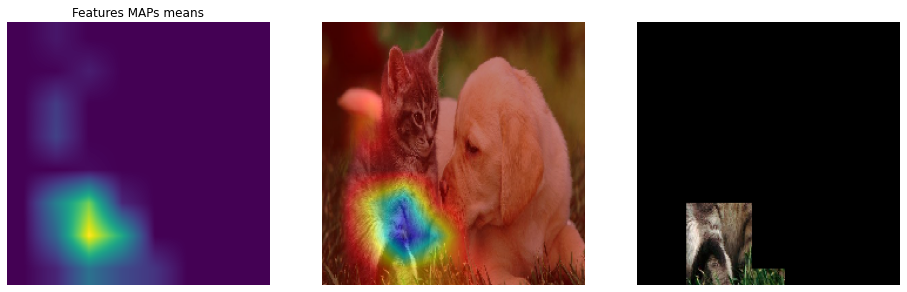

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


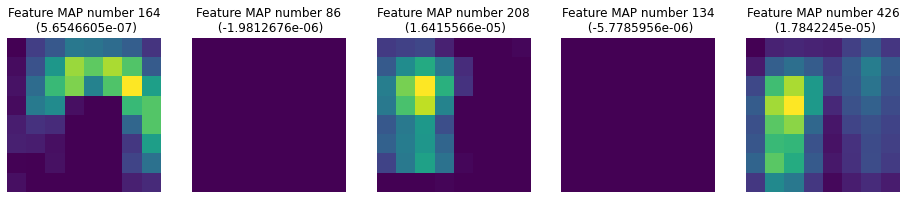

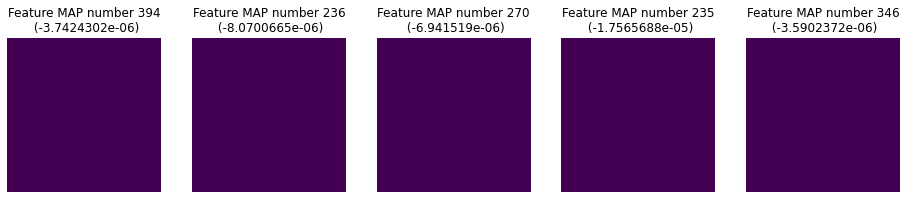

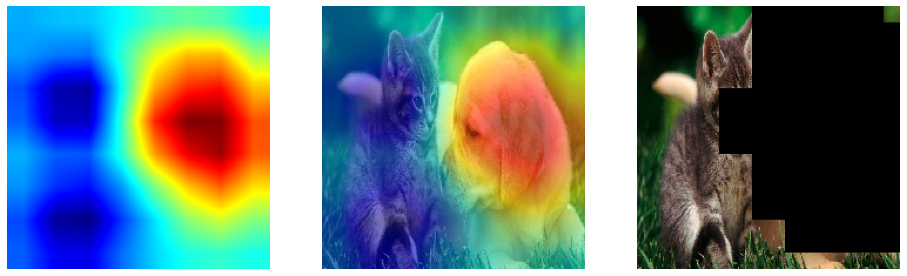

In [14]:
iamge_path = 'test/test5.jpg'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19', cat_class_index=0)

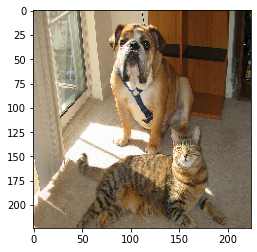

[[0.4472001 0.5528   ]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  dog
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


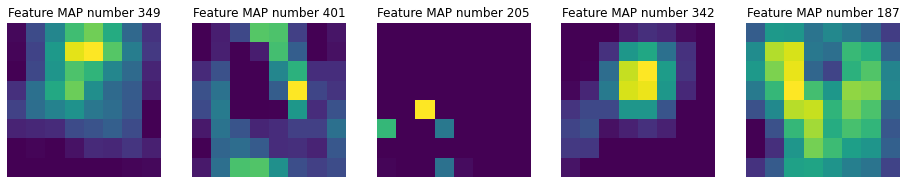

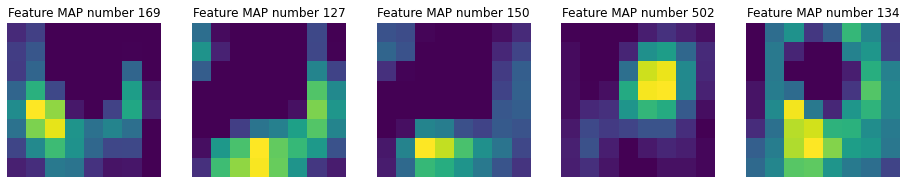

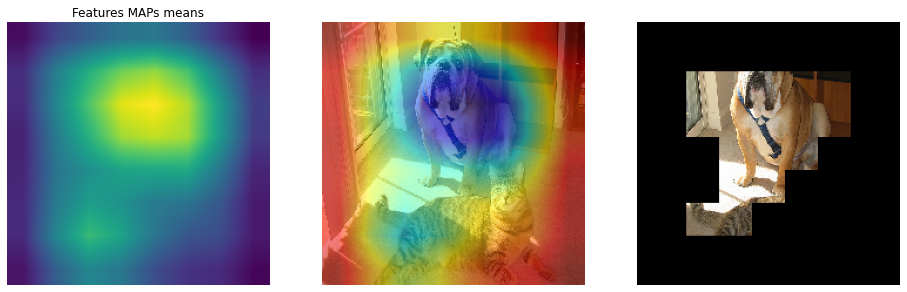

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


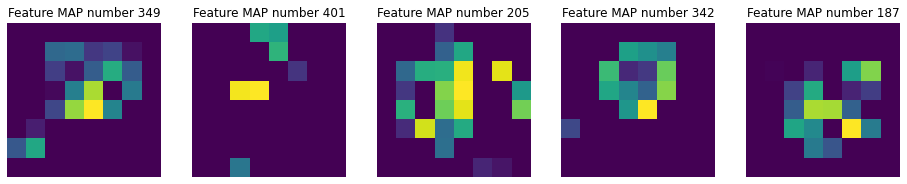

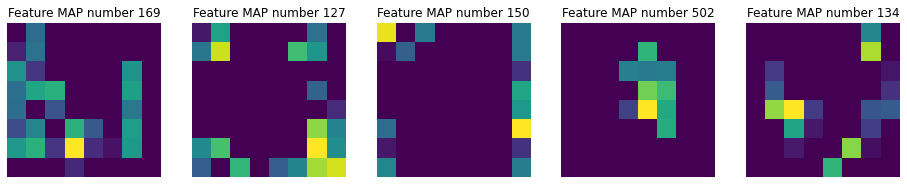

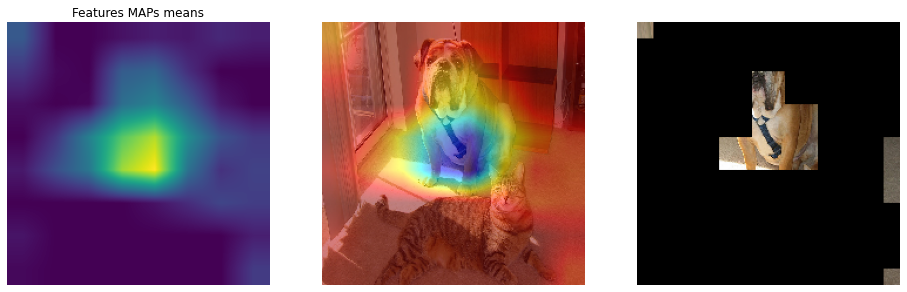

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


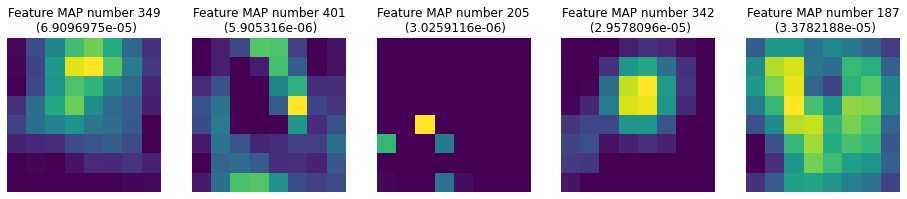

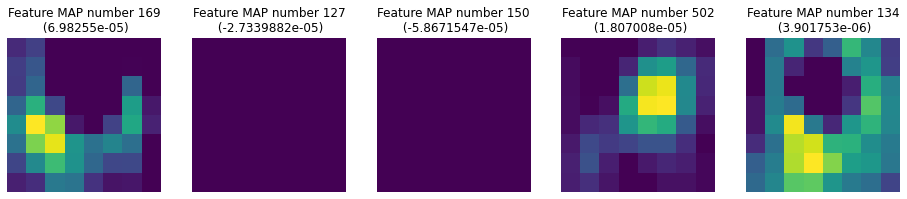

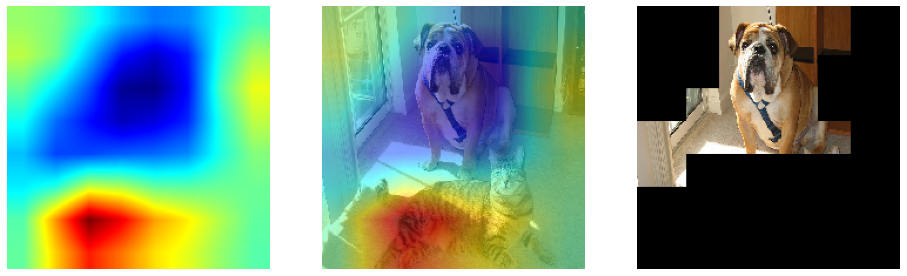

In [16]:
iamge_path = 'test/test7.png'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19')

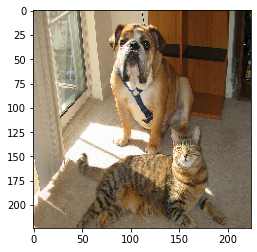

[[0.4472001 0.5528   ]]
La classe prédite est dog

----------------------------------------------------
Affichage des heatmaps pour la classe  cat
----------------------------------------------------

HEATMAP WITH WEIGTH AFTER TRAINING
----------------------------------


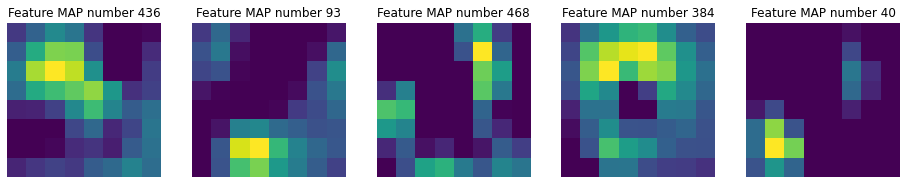

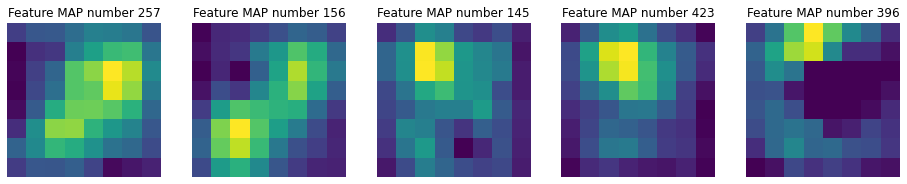

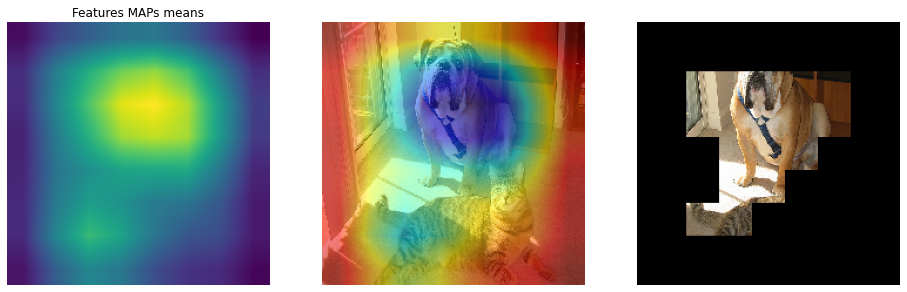

HEATMAP WITH GRADIENT AFTER TRAINING
------------------------------------


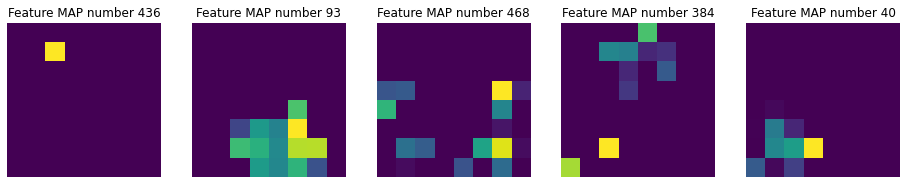

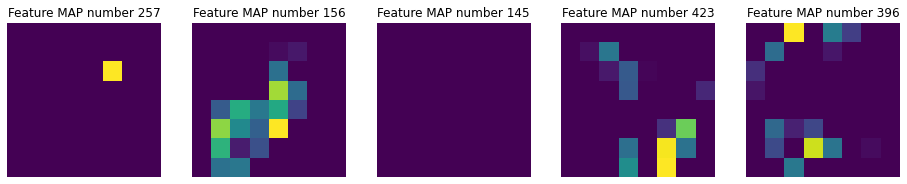

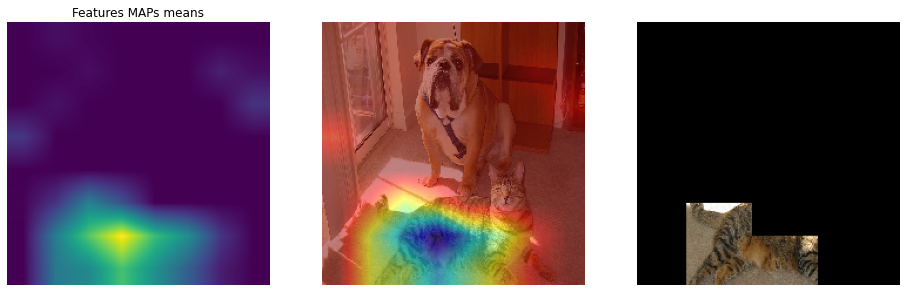

HEATMAP WITH GRAD-CAM AFTER TRAINING
------------------------------------


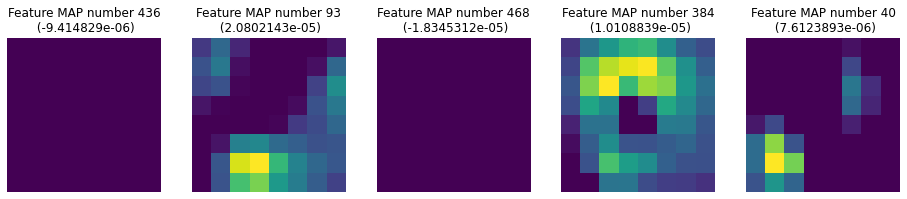

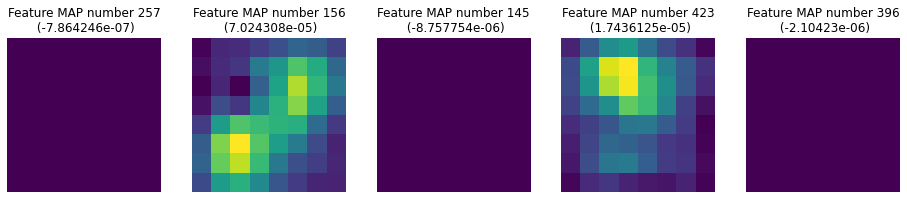

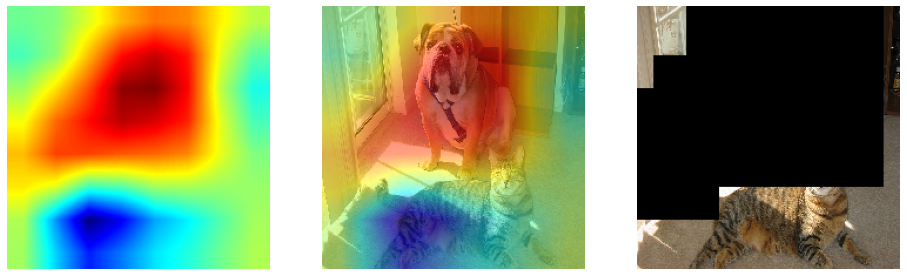

In [17]:
iamge_path = 'test/test7.png'

img = tf.keras.preprocessing.image.load_img(iamge_path, target_size=(224, 224))
image_array = tf.keras.preprocessing.image.img_to_array(img)
image_div = image_array / 255

plt.imshow(np.array(img))
plt.show()
print(model.predict(np.array([image_div])))
preds = np.argmax(model.predict(np.array([image_div])), axis=-1)
print('La classe prédite est {}'.format(labels[preds[0]]))
print('')

grad_cam(model, img, 'conv2d_19', cat_class_index=0)